In [102]:
import polars as pl
import numpy as np
from matplotlib import pyplot as plt
import os
import json
import pandas as pd
import seaborn as sns
from scipy.sparse import csr_matrix
os.chdir(os.path.expanduser('~/vivarium-ecoli'))


In [103]:
def read_names(file_path):
    return np.genfromtxt(file_path, dtype=str, delimiter="\n")

def read_matrix(file_path, sparse=False):
    # add sparse matrix reading
    if sparse:
        return csr_matrix(pl.read_csv(file_path, has_header=False).to_numpy())
    else:
        return pl.read_csv(file_path, has_header=False).to_numpy()


Cmatrix = read_matrix("notebooks/mia notebooks/C_matrix.csv", sparse=True)
complex_ids = list(read_names("notebooks/mia notebooks/complex_ids.txt"))
monomer_ids = list(read_names("notebooks/mia notebooks/monomer_ids.txt"))
# Ecocyc data (https://ecocyc.org/groups?tab=SPECIAL&orgid=ECOLI): 
ecocyc_data = pd.read_excel("notebooks/mia notebooks/All_polypeptides_from_ecocyc_data.xlsx")
# validation data (https://www.sciencedirect.com/science/article/pii/S0092867414002323?via%3Dihub#app1):
validation_data = pd.read_excel("notebooks/mia notebooks/data_from_li_et_al_2014.xlsx")

## Minimal Media Conditions Comparison of simulation data with data from Li et al., 2014 

In [104]:
time = '1300'
date = '2024-04-29'
experiment = 'validation_experiment'
entry = f'{experiment}_{time}_{date}'
folder = f'out/cofactors/{entry}/'

In [105]:
output_all = np.load(folder + '0_output.npy',allow_pickle='TRUE').item()
# output = np.load(r"out/geneRxnVerifData/output_glc.npy", allow_pickle=True, encoding='ASCII').tolist()
output = output_all['agents']['0']
fba = output['listeners']['fba_results']
mass = output['listeners']['mass']
bulk = pl.DataFrame(output['bulk'])

fluxes = np.array(fba['estimated_fluxes'][1:])
exchanges = fba['estimated_exchange_dmdt']

ans = output['listeners']['unique_molecule_counts']['active_ribosome']

In [106]:
# So say I want to find the names of the proteins themselves, these are functions to implement that do so: 
initial_state = json.load(open('data/wcecoli_t0.json'))

bulk_ids = [item[0] for item in initial_state['bulk']]

bulk.columns = bulk_ids

In [127]:
# Combine monomers in different compartments into one monomer id: 
id_idx_dict = {id: i for i, id in enumerate(bulk_ids)}
idx_id_dict = {idx: i for i, idx in id_idx_dict.items()}

# take the protein [location] out of the name of the bulk ids: 
ecocyc_ids = []
for id in bulk_ids: 
	ecocyc_ids.append(id[0:-3])

ecocyc_id_idxs = []
for i in range(len(ecocyc_ids)):
	ecocyc_id_idxs.append(i)
	
all_names = [] # ends with 12726 total (down from 16097)
name_groups = []
idx_groups = []

for p in bulk_ids:
	prot = p[0:-3]
	if prot not in all_names:
		indexes = [index for index, item in enumerate(ecocyc_ids) if item == prot]
		for idx in indexes:
			if ecocyc_ids[idx] == prot:
				# confirm the index is correct
				pass
			else:
				# delete the index in case a mistake was made
				indexes.remove(idx)
		name_group = [idx_id_dict.get(name) for name in indexes]
		all_names.append(prot)
		name_groups.append(name_group)
		idx_groups.append(indexes)
		
len(all_names)
len(name_groups)

12726

In [141]:
# figure out which proteins from the C matrix match those in the bulk data: 
protein_ids = complex_ids + monomer_ids
protein_counts = np.zeros([bulk.shape[0], len(protein_ids)])
pid_idx_dict = {id: i for i, id in enumerate(protein_ids)}
idx_pid_dict = {idx: i for i, idx in pid_idx_dict.items()}

for p in protein_ids:
	idx = [index for index, item in enumerate(all_names) if item == p]
	if len(idx) == 0:
		protein_counts[:, pid_idx_dict[p]] = 0
	elif len(idx) == 1:
		name = all_names[idx[0]]
		idx_group = idx_groups[idx[0]]
		temp_counts = np.zeros([bulk.shape[0], len(idx_group)])
		for i in range(len(idx_group)):
			selected_data = bulk.select(bulk_ids[idx_group[i]]) 
			temp_counts[:, i] = selected_data.to_numpy().flatten()
		protein_counts[:, pid_idx_dict[p]] = np.sum(temp_counts, axis=1)
	else:
		# make sure there are no bugs in the code
		print(p)
		print("too many")
	

In [142]:
np.shape(protein_counts)

(1301, 5527)

In [151]:
mm_sim_protein_counts = protein_counts @ Cmatrix
# simplify the results accordingly with the time steps: 
mm_avg_sim_data = mm_sim_protein_counts.mean(axis=0)
# TODO: edit this to account for cell age
# create dataframes for the simulation data:
mm_avg_sim_df = pl.DataFrame((monomer_ids, mm_avg_sim_data), schema=["Monomer ID","Sim Protein Counts"])

In [152]:
mm_avg_sim_df

Monomer ID,Sim Protein Counts
str,f64
"""1-ACYLGLYCEROL…",142.265181
"""1-PFK-MONOMER""",55.0
"""2-DEHYDROPANTO…",290.760953
"""2-ISOPROPYLMAL…",1535.616449
"""2-OCTAPRENYL-M…",294.806303
…,…
"""YTFR-MONOMER""",25.0
"""YTFT-MONOMER""",20.0
"""ZNUA-MONOMER""",609.390469


In [155]:
new_df = pl.DataFrame(ecocyc_data).join(mm_avg_sim_df,  how="inner", left_on="Proteins", right_on="Monomer ID")
# TODO: so the length of the original ecocyc data frame is 4481, so I think that it is filtering correctly! 
new_df

Proteins,Genes,Accession-1 of Gene,Common-Name,Sim Protein Counts
str,str,str,str,f64
"""EG11817-MONOME…","""EG11817""","""b2744""","""umpG""",56.18063
"""MONOMER0-4534""","""G6577""","""b1120""","""cobB""",240.740968
"""FDOI-MONOMER""","""EG11856""","""b3892""","""fdoI""",14.0
"""G6991-MONOMER""","""G6991""","""b1807""","""tsaB""",202.0
"""ADENODEAMIN-MO…","""EG10030""","""b1623""","""add""",199.641814
…,…,…,…,…
"""G7835-MONOMER""","""G7835""","""b4145""","""yjeJ""",63.249039
"""GALACTITOLPDEH…","""EG12417""","""b2091""","""gatD""",206.0
"""EG10736-MONOME…","""EG10736""","""b0708""","""phr""",38.804766


In [156]:
# Remove rows from validation_data that do not have high confidence (they will contain brackets) in the "MOPS complete" column:
validation_data['MOPS minimal'] = validation_data['MOPS minimal'].astype(str)
validation_data = validation_data[~validation_data['MOPS minimal'].str.contains("[", regex=False)]
validation_data = validation_data[validation_data['MOPS minimal'].str.isdigit()]
validation_data['MOPS minimal'] = validation_data['MOPS minimal'].astype(int)
v_mm_data = validation_data[['Gene', 'MOPS minimal']]
v_mm_data = pl.DataFrame(v_mm_data)
v_mm_data

Gene,MOPS minimal
str,i64
"""aaeA""",5
"""aaeR""",79
"""aas""",80
"""aat""",111
"""abgA""",12
…,…
"""zraR""",30
"""zraS""",4
"""zupT""",217


In [157]:
# find matches between the simulation minimal media data and validation minimal media data: 
vs_match_mm_df = pl.DataFrame(new_df).join(v_mm_data,  how="inner", left_on="Common-Name", right_on="Gene")
vs_match_mm_df

Proteins,Genes,Accession-1 of Gene,Common-Name,Sim Protein Counts,MOPS minimal
str,str,str,str,f64,i64
"""MONOMER0-4534""","""G6577""","""b1120""","""cobB""",240.740968,572
"""FDOI-MONOMER""","""EG11856""","""b3892""","""fdoI""",14.0,16
"""ADENODEAMIN-MO…","""EG10030""","""b1623""","""add""",199.641814,265
"""EG10875-MONOME…","""EG10875""","""b3310""","""rplN""",14345.242121,18836
"""G6605-MONOMER""","""G6605""","""b1165""","""ymgA""",13.074558,43
…,…,…,…,…,…
"""G7835-MONOMER""","""G7835""","""b4145""","""yjeJ""",63.249039,19
"""GALACTITOLPDEH…","""EG12417""","""b2091""","""gatD""",206.0,2360
"""EG10736-MONOME…","""EG10736""","""b0708""","""phr""",38.804766,37


In [161]:
# make a new data frame that holds just the protein names and the Sim Protein Counts and MOPS minimal data and then filter out counts that are less than 10: 
comparison_data = ["Proteins", "Sim Protein Counts", "MOPS minimal"]
comparison_df = vs_match_mm_df.select(comparison_data)
comparison_df = comparison_df.filter((pl.col("Sim Protein Counts") > 10) & (pl.col("MOPS minimal") > 10))
comparison_df

Proteins,Sim Protein Counts,MOPS minimal
str,f64,i64
"""MONOMER0-4534""",240.740968,572
"""FDOI-MONOMER""",14.0,16
"""ADENODEAMIN-MO…",199.641814,265
"""EG10875-MONOME…",14345.242121,18836
"""G6605-MONOMER""",13.074558,43
…,…,…
"""G7835-MONOMER""",63.249039,19
"""GALACTITOLPDEH…",206.0,2360
"""EG10736-MONOME…",38.804766,37


In [163]:
# plot the comparison graph:
# filtered over ten graph:
mm_df = pl.DataFrame(np.array([comparison_df.select("Sim Protein Counts"), comparison_df.select("MOPS minimal")]).T, schema=["Simulation", "Experiment"])
sns.scatterplot(x="Simulation", y="Experiment", data=mm_df.to_pandas(), s=5)
#sns.scatterplot(x="Sim Protein Counts", y="MOPS minimal", data=comparison_df.to_pandas(), s=5)

# find the max value of the plot for making a y=x line: 
max_vals = [max(comparison_df.select("Sim Protein Counts")), max(comparison_df.select("MOPS minimal"))]; max_val = round(max(max_vals))
yxvals = range(10, max_val + 1); 
plt.plot(yxvals, yxvals, linewidth=.8, linestyle="dashed", color="#FF796C"); 

# plot specs
plt.xscale('log')
plt.yscale('log')
plt.axis('square')
plt.title("Comparisons of E.coli Protein Counts in Minimal Media \n from Literature Data and Simulation Data")

ValueError: cannot create DataFrame from array with more than two dimensions; shape = (1, 2651, 2)

## Old solving method: 

In [52]:
# find the gene name for each monomer in the bulk data using Ecocyc data: 
mm_BD_gene_ids = []
mm_monomers_not_in_EC = []
mm_monomer_idxs_in_EC = []
gene = 1
for i in range(len(monomer_ids)):
	if gene not in mm_BD_gene_ids: 
		monomer = monomer_ids[i]
		monomer_idx = [name for key, name in EC_id_idx_dict.items() if monomer in key]
		if len(monomer_idx) == 0:
			mm_monomers_not_in_EC.append(monomer)
		else: 
			monomer_idx = monomer_idx[0]
			gene = EC_idx_Gene_dict.get(monomer_idx)
			mm_BD_gene_ids.append([gene])
			mm_monomer_idxs_in_EC.append(i)
			
len(mm_BD_gene_ids)
# join mm_BD_gene_ids with ecocyc_data on protein names
# do a join type where it will only keep the keys both share 
# TODO: replace the code above this with just the line below!!! <3 
new_df = pl.DataFrame(ecocyc_data).join(mm_avg_sim_df,  how="inner", left_on="Proteins", right_on="Monomer ID")
new_df


Proteins,Genes,Accession-1 of Gene,Common-Name,Protein Count
str,str,str,str,f64
"""EG11817-MONOME…","""EG11817""","""b2744""","""umpG""",56.18063
"""MONOMER0-4534""","""G6577""","""b1120""","""cobB""",240.740968
"""FDOI-MONOMER""","""EG11856""","""b3892""","""fdoI""",14.0
"""G6991-MONOMER""","""G6991""","""b1807""","""tsaB""",202.0
"""ADENODEAMIN-MO…","""EG10030""","""b1623""","""add""",199.641814
…,…,…,…,…
"""G7835-MONOMER""","""G7835""","""b4145""","""yjeJ""",63.249039
"""GALACTITOLPDEH…","""EG12417""","""b2091""","""gatD""",206.0
"""EG10736-MONOME…","""EG10736""","""b0708""","""phr""",38.804766


In [53]:
# merge the simulation data with the ecocyc data:
new_df = pl.DataFrame(ecocyc_data).join(mm_avg_sim_df,  how="inner", left_on="Proteins", right_on="Monomer ID")
# TODO: so the length of the original ecocyc data frame is 4481, so I think that it is filtering correctly! 
new_df

Proteins,Genes,Accession-1 of Gene,Common-Name,Protein Count
str,str,str,str,f64
"""EG11817-MONOME…","""EG11817""","""b2744""","""umpG""",56.18063
"""MONOMER0-4534""","""G6577""","""b1120""","""cobB""",240.740968
"""FDOI-MONOMER""","""EG11856""","""b3892""","""fdoI""",14.0
"""G6991-MONOMER""","""G6991""","""b1807""","""tsaB""",202.0
"""ADENODEAMIN-MO…","""EG10030""","""b1623""","""add""",199.641814
…,…,…,…,…
"""G7835-MONOMER""","""G7835""","""b4145""","""yjeJ""",63.249039
"""GALACTITOLPDEH…","""EG12417""","""b2091""","""gatD""",206.0
"""EG10736-MONOME…","""EG10736""","""b0708""","""phr""",38.804766


In [54]:
# validation data sets from Li et al., 2014 (https://www.sciencedirect.com/science/article/pii/S0092867414002323?via%3Dihub#app1):
validation_genes = validation_data.Gene
validation_MOPS_data = validation_data['MOPS complete']
validation_MOPS_min = validation_data['MOPS minimal']
validation_MOPS_wo_M = validation_data['MOPS complete without methionine']

# organize validation genes:
V_gene_idx_dict = {id: i for i, id in enumerate(validation_genes)}
V_idx_gene_dict = {idx: i for i, idx in V_gene_idx_dict.items()}

In [55]:
# test out loading in the data from Ecocyc (https://ecocyc.org/groups?tab=SPECIAL&orgid=ECOLI) using the polars methods: 
test_df = pl.read_csv("notebooks/mia notebooks/test_name_df.csv", separator="\t", truncate_ragged_lines=True)
test_df
#TODO: why do I have this code here? is it not the same as "ecocyc_data"?

Proteins,Genes,Accession-1 of Gene,Common-Name
str,str,str,str
"""LYSU-CPLX""","""EG10553""","""b4129""","""lysU"""
"""EG11817-MONOME…","""EG11817""","""b2744""","""umpG"""
"""MONOMER0-4534""","""G6577""","""b1120""","""cobB"""
"""FDOI-MONOMER""","""EG11856""","""b3892""","""fdoI"""
"""G6991-MONOMER""","""G6991""","""b1807""","""tsaB"""
…,…,…,…
"""G7835-MONOMER""","""G7835""","""b4145""","""yjeJ"""
"""GALACTITOLPDEH…","""EG12417""","""b2091""","""gatD"""
"""EG10736-MONOME…","""EG10736""","""b0708""","""phr"""


In [56]:
ecocyc_data

,Proteins,Genes,Accession-1 of Gene,Common-Name
0,LYSU-CPLX,EG10553,b4129,lysU
1,EG11817-MONOMER,EG11817,b2744,umpG
2,MONOMER0-4534,G6577,b1120,cobB
3,FDOI-MONOMER,EG11856,b3892,fdoI
4,G6991-MONOMER,G6991,b1807,tsaB
...,...,...,...,...
4476,G7835-MONOMER,G7835,b4145,yjeJ
4477,GALACTITOLPDEHYD-MONOMER,EG12417,b2091,gatD
4478,EG10736-MONOMER,EG10736,b0708,phr
4479,EG10853-MONOMER,EG10853,b1427,rimL


In [57]:
validation_data

,Gene,MOPS complete,MOPS minimal,MOPS complete without methionine
0,aaeA,62,5,[21]
1,aaeB,16,[2],[0]
2,aaeR,203,79,141
3,aaeX,[28],[5],[11]
4,aas,188,80,162
...,...,...,...,...
4090,zraR,98,30,50
4091,zraS,8,4,[0]
4092,zupT,407,217,295
4093,zur,333,167,582


In [58]:
# Remove rows from validation_data that do not have high confidence (they will contain brackets) in the "MOPS complete" column:
validation_data['MOPS minimal'] = validation_data['MOPS minimal'].astype(str)
validation_data = validation_data[~validation_data['MOPS minimal'].str.contains("[", regex=False)]
validation_data = validation_data[validation_data['MOPS minimal'].str.isdigit()]
validation_data['MOPS minimal'] = validation_data['MOPS minimal'].astype(int)
v_mm_data = validation_data[['Gene', 'MOPS minimal']]
v_mm_data = pl.DataFrame(v_mm_data)
v_mm_data

Gene,MOPS minimal
str,i64
"""aaeA""",5
"""aaeR""",79
"""aas""",80
"""aat""",111
"""abgA""",12
…,…
"""zraR""",30
"""zraS""",4
"""zupT""",217


In [59]:
# Filter out less confident data from the validation data set: 
mm_V_data = []
mm_V_data_idxs = []
mm_V_data_unsure = []
for i in range(len(validation_MOPS_min)):
	PC = validation_MOPS_min[i]
	# if the data is not confident enough, indicated by brackets, then leave it out
	if type(PC) == str:
		PC = PC.replace("[",""); PC = PC.replace("]","") # TODO: use pl. string replace function
		PC = int(PC)
		mm_V_data_unsure.append(PC)
	else:
		int(PC)
		mm_V_data.append(PC)
		mm_V_data_idxs.append(i)

len(mm_V_data)

# Extract the remaining gene names of the simulation data: 
mm_V_data_gene_ids = []
for i in range(len(mm_V_data)):
	idx = mm_V_data_idxs[i]
	gene_id = V_idx_gene_dict.get(idx)
	mm_V_data_gene_ids.append(gene_id)
	
# Reorganize the validation gene data set: 
mm_V_gene_idx_dict = {id: i for i, id in enumerate(mm_V_data_gene_ids)}
mm_V_idx_gene_dict = {idx: i for i, idx in mm_V_gene_idx_dict.items()}
len(mm_V_data_gene_ids)

3362

In [60]:
# find matches between the simulation minimal media data and validation minimal media data: 
mm_matches = []
mm_V_match_idxs = []
mm_sim_gene_idxs = []
mm_non_matches = []

G = 1
for i in range(len(mm_BD_gene_ids)):
	if G not in mm_matches: 
		G = (mm_BD_gene_ids[i])
		G = str(G[0])
		gene_idx = [name for key, name in mm_V_gene_idx_dict.items() if G in key]
		if len(gene_idx) == 0:
			mm_non_matches.append(G)
		else: 
			gene_idx = gene_idx[0]
			mm_V_match_idxs.append(gene_idx)
			gene = mm_V_idx_gene_dict.get(gene_idx)
			mm_matches.append([gene])
			mm_sim_gene_idxs.append(i)
		
len(mm_matches)

3018

In [61]:
# find matches between the simulation minimal media data and validation minimal media data: 
vs_match_mm_df = pl.DataFrame(new_df).join(v_mm_data,  how="inner", left_on="Common-Name", right_on="Gene")
vs_match_mm_df

Proteins,Genes,Accession-1 of Gene,Common-Name,Protein Count,MOPS minimal
str,str,str,str,f64,i64
"""MONOMER0-4534""","""G6577""","""b1120""","""cobB""",240.740968,572
"""FDOI-MONOMER""","""EG11856""","""b3892""","""fdoI""",14.0,16
"""ADENODEAMIN-MO…","""EG10030""","""b1623""","""add""",199.641814,265
"""EG10875-MONOME…","""EG10875""","""b3310""","""rplN""",14345.242121,18836
"""G6605-MONOMER""","""G6605""","""b1165""","""ymgA""",13.074558,43
…,…,…,…,…,…
"""G7835-MONOMER""","""G7835""","""b4145""","""yjeJ""",63.249039,19
"""GALACTITOLPDEH…","""EG12417""","""b2091""","""gatD""",206.0,2360
"""EG10736-MONOME…","""EG10736""","""b0708""","""phr""",38.804766,37


In [62]:
# Extract data columns from monomers not found in the Ecocyc data (corresponding to the names in BD_gene_ids): 
mm_avg_sim_PCs = mm_avg_sim_data[mm_monomer_idxs_in_EC]

# Map the genes that do match together (corresponding to the names in matches): 
mm_avg_sim_PCs = np.transpose(mm_avg_sim_PCs)
mm_sim_PC_data = mm_avg_sim_PCs[mm_sim_gene_idxs]

# obtain minimal media validation data that can be compared with simulation data: 
mm_v_MOPS_data = []
mm_v_MOPS_ids = []
for idx in mm_V_match_idxs: 
	gene_id = mm_V_data_gene_ids[idx]
	mm_v_MOPS_ids.append(gene_id)
	PC_data = mm_V_data[idx]
	mm_v_MOPS_data.append(PC_data)
	
len(mm_v_MOPS_data)

3018

Text(0.5, 1.0, 'Comparisons of E.coli Protein Counts in Minimal Media Conditions \n between Literature Data and Simulation Data')

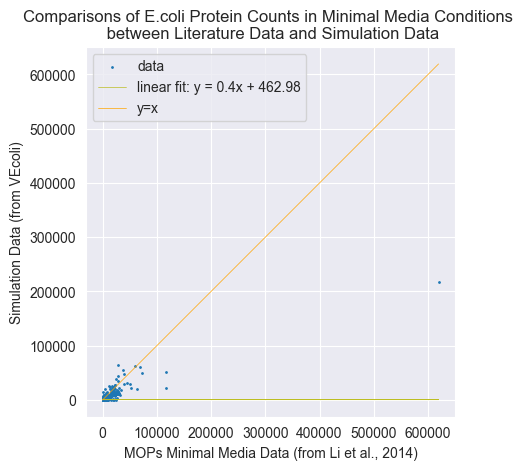

In [63]:
# Plot the minimal media comparison graph using matplotlib:
mm_xdata = np.array(mm_v_MOPS_data); mm_ydata = np.array(mm_sim_PC_data)
plt.scatter(mm_xdata+1, mm_ydata+1, s=1, label="data")

m, b = np.polyfit(mm_xdata, mm_ydata, 1)
mm_Y_data = int(m) * mm_xdata + b
mm_legend_str = "linear fit: y = "+ str(round(m, 2)) +"x + "+ str(round(b, 2))
plt.plot(mm_xdata, mm_Y_data, linewidth=.5, color='#bcbd22', label=mm_legend_str)

max_value = max(max(mm_xdata), max(mm_ydata))
x=y=[i for i in range(0,max_value)]
plt.plot(x, y, linewidth=.5, color="orange", label="y=x")

plt.axis('square')
plt.legend()
plt.xlabel("MOPs Minimal Media Data (from Li et al., 2014)")
plt.ylabel("Simulation Data (from VEcoli)")
plt.title("Comparisons of E.coli Protein Counts in Minimal Media Conditions \n between Literature Data and Simulation Data")

Text(0.5, 1.0, 'Comparisons of E.coli Protein Counts in Minimal Media \n from Literature Data and Simulation Data')

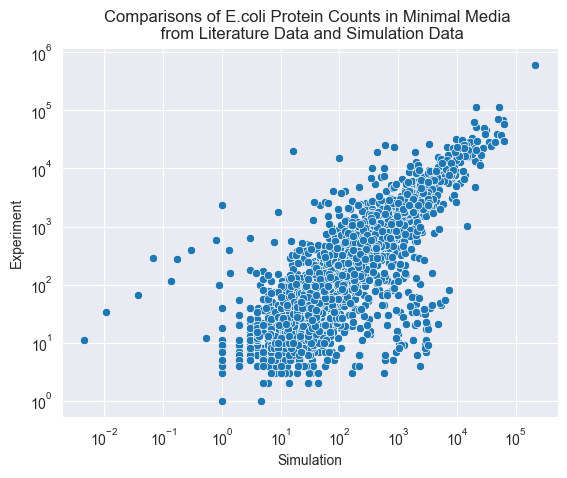

In [64]:
# Plot using the Polars dataframe method and Seaborn plotting method:
comparison_df = pl.DataFrame(np.array([mm_v_MOPS_data, mm_sim_PC_data]).T, schema=["Experiment", "Simulation"])

sns.scatterplot(x="Simulation", y="Experiment", data=comparison_df.to_pandas())

plt.xscale('log')
plt.yscale('log')
plt.title("Comparisons of E.coli Protein Counts in Minimal Media \n from Literature Data and Simulation Data")

In [65]:
# taking out the counts with proteins that are in abundance of less than 10 (likely subgenerational) 
idxs_over_10 = []
mm_v_MOPS_data_10 =[]
mm_sim_PC_data_10 = []
for i in range(len(mm_v_MOPS_data)): 
	MOPS_data = mm_v_MOPS_data[i]
	sim_data = mm_sim_PC_data[i]
	if MOPS_data > 10: 
		if sim_data > 10: 
			idxs_over_10.append(i)
			mm_v_MOPS_data_10.append(MOPS_data)
			mm_sim_PC_data_10.append(sim_data)
			
			
			

In [66]:
comparison_df = comparison_df.filter((pl.col("Experiment") > 10) & (pl.col("Simulation") > 10))

Text(0.5, 1.0, 'Comparisons of E.coli Protein Counts in Minimal Media \n from Literature Data and Simulation Data')

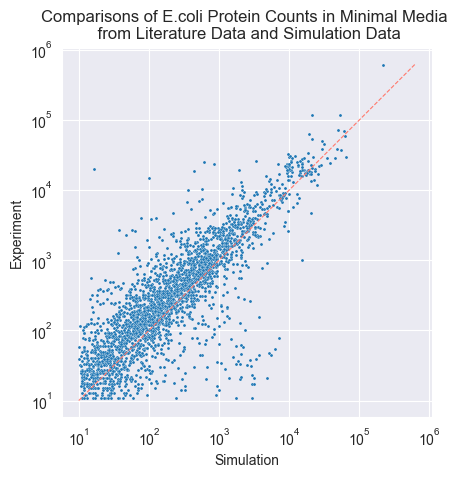

In [67]:
# filtered over ten graph: 
comparison_df = pl.DataFrame(np.array([mm_v_MOPS_data_10, mm_sim_PC_data_10]).T, schema=["Experiment", "Simulation"])
sns.scatterplot(x="Simulation", y="Experiment", data=comparison_df.to_pandas(), s=5)

# find the max value of the plot for making a y=x line: 
max_vals = [max(mm_v_MOPS_data_10), max(mm_sim_PC_data_10)]; max_val = round(max(max_vals))
yxvals = range(10, max_val + 1); 
plt.plot(yxvals, yxvals, linewidth=.8, linestyle="dashed", color="#FF796C"); 

# plot specs
plt.xscale('log')
plt.yscale('log')
plt.axis('square')
plt.title("Comparisons of E.coli Protein Counts in Minimal Media \n from Literature Data and Simulation Data")

In [68]:
# find the geometric deviation from the y=x line:
# command {}


In [69]:

comparison_df.sum()

Experiment,Simulation
f64,f64
5.346269e6,3.5105e6


## Comparison of rich media data from simulation results and Li et al., 2014

In [70]:
time = '1300'
date = '2024-04-23'
experiment = 'validation_experiment'
entry = f'{experiment}_{time}_{date}'
folder = f'out/cofactors/{entry}/'

In [71]:
output_all = np.load(folder + '0_output.npy',allow_pickle='TRUE').item()
# output = np.load(r"out/geneRxnVerifData/output_glc.npy", allow_pickle=True, encoding='ASCII').tolist()
output = output_all['agents']['0']
fba = output['listeners']['fba_results']
mass = output['listeners']['mass']
bulk = pl.DataFrame(output['bulk'])

fluxes = np.array(fba['estimated_fluxes'][1:])
exchanges = fba['estimated_exchange_dmdt']

ans = output['listeners']['unique_molecule_counts']['active_ribosome']

In [72]:
# So say I want to find the names of the proteins themselves, these are functions to implement that do so: 
initial_state = json.load(open('data/wcecoli_t0.json'))

bulk_ids = [item[0] for item in initial_state['bulk']]

bulk.columns = bulk_ids

In [73]:
# take the protein [location] out of the name of the bulk ids: 
ecocyc_ids = []
for id in bulk_ids: 
	ecocyc_ids.append(id[0:-3])

ecocyc_id_idxs = []
for i in range(len(ecocyc_ids)):
	ecocyc_id_idxs.append(i)

In [74]:
# combine the protein counts for each monomer: 
id_idx_dict = {id: i for i, id in enumerate(bulk_ids)}
idx_id_dict = {idx: i for i, idx in id_idx_dict.items()}

protein_ids = complex_ids + monomer_ids
all_names = []
name_groups = []
idx_groups = []

for p in protein_ids:
	if p not in all_names:
		indexes = [name for key, name in id_idx_dict.items() if p in key]
		for idx in indexes:
			if ecocyc_ids[idx] == p:
				pass
			else:
				indexes.remove(idx)
		name_group = [idx_id_dict.get(name) for name in indexes]
		all_names.append(p)
		name_groups.append([name_group])
		idx_groups.append([indexes])

In [75]:
# fuse and collect protein counts of interest (in the C matrix): 
MM_bulk_interest_protein_counts = np.zeros([bulk.shape[0], len(protein_ids)])
MM_bulk_PC_dict = {}

for i in range(len(idx_groups)):
	id = protein_ids[i]
	idxs = idx_groups[i]
	if id in ecocyc_ids:
		if len(idxs) == 1:
			idx = idxs[0][0]
			df = np.array(bulk.select(bulk_ids[idx]))
		else:
			together = []
			for idx in idxs:
				index = idx[0]
				temp_df = np.array(bulk.select(bulk_ids[index]))
				together.append(temp_df)
			df = np.sum(together, axis=1)
		protein_counts = np.transpose(df)
		MM_bulk_interest_protein_counts[:, i] = protein_counts
		MM_bulk_PC_dict.update({id:idxs}) 

In [76]:
# Generate simulation data: 
MM_sim_protein_counts = MM_bulk_interest_protein_counts @ Cmatrix

# average the data across the timepoints accordingly: 
MM_avg_sim_data = MM_sim_protein_counts.mean(axis=0)

In [77]:
# Data from Ecocyc (https://ecocyc.org/groups?tab=SPECIAL&orgid=ECOLI): 
EC_proteins = ecocyc_data.Proteins
EC_genes = ecocyc_data.Genes
EC_gene_CNs = ecocyc_data['Common-Name']

# organize Ecocyc protein name and gene name data: 
EC_id_idx_dict = {id: i for i, id in enumerate(EC_proteins)}
EC_idx_id_dict = {idx: i for i, idx in EC_id_idx_dict.items()}

EC_Gene_idx_dict = {id: i for i, id in enumerate(EC_gene_CNs)}
EC_idx_Gene_dict = {idx: i for i, idx in EC_Gene_idx_dict.items()}

In [78]:
# find the gene name for each monomer in the bulk data using Ecocyc data: 
MM_BD_gene_ids = []
MM_monomers_not_in_EC = []
MM_monomer_idxs_in_EC = []
gene = 1
for i in range(len(monomer_ids)):
	if gene not in MM_BD_gene_ids: 
		monomer = monomer_ids[i]
		monomer_idx = [name for key, name in EC_id_idx_dict.items() if monomer in key]
		if len(monomer_idx) == 0:
			MM_monomers_not_in_EC.append(monomer)
		else: 
			monomer_idx = monomer_idx[0]
			gene = EC_idx_Gene_dict.get(monomer_idx)
			MM_BD_gene_ids.append([gene])
			MM_monomer_idxs_in_EC.append(i)
			
len(MM_BD_gene_ids)

4321

In [79]:
# validation data sets from Li et al., 2014 (https://www.sciencedirect.com/science/article/pii/S0092867414002323?via%3Dihub#app1):
validation_genes = validation_data.Gene
validation_MOPS_data = validation_data['MOPS complete']
validation_MOPS_min = validation_data['MOPS minimal']
validation_MOPS_wo_M = validation_data['MOPS complete without methionine']

# organize validation genes:
V_gene_idx_dict = {id: i for i, id in enumerate(validation_genes)}
V_idx_gene_dict = {idx: i for i, idx in V_gene_idx_dict.items()}

In [80]:
# Filter out less confident data from the validation data set: 
MM_V_data = []
MM_V_data_idxs = []
MM_V_data_unsure = []
for i in range(len(validation_MOPS_data)):
	PC = validation_MOPS_data[i]
	# if the data is not confident enough, indicated by brackets, then leave it out
	if type(PC) == str:
		PC = PC.replace("[",""); PC = PC.replace("]","")
		PC = int(PC)
		MM_V_data_unsure.append(PC)
	else:
		int(PC)
		MM_V_data.append(PC)
		MM_V_data_idxs.append(i)

len(MM_V_data)

# Extract the remaining gene names of the simulation data: 
MM_V_data_gene_ids = []
for i in range(len(MM_V_data)):
	idx = MM_V_data_idxs[i]
	gene_id = V_idx_gene_dict.get(idx)
	MM_V_data_gene_ids.append(gene_id)
	
len(MM_V_data_gene_ids)

# Reorganize the validation gene data set: 
MM_V_gene_idx_dict = {id: i for i, id in enumerate(MM_V_data_gene_ids)}
MM_V_idx_gene_dict = {idx: i for i, idx in MM_V_gene_idx_dict.items()}

KeyError: 1

In [ ]:
MM_V_data_gene_ids

In [ ]:
# find matches between the simulation data and validation data: 
MM_matches = []
MM_V_match_idxs = []
MM_sim_match_idxs = []
MM_non_matches = []

G = 1
for i in range(len(MM_BD_gene_ids)):
	if G not in MM_matches: 
		G = (MM_BD_gene_ids[i])
		G = str(G[0])
		gene_idx = [name for key, name in MM_V_gene_idx_dict.items() if G in key]
		if len(gene_idx) == 0:
			MM_non_matches.append(G)
		else: 
			gene_idx = gene_idx[0]
			MM_V_match_idxs.append(gene_idx)
			gene = MM_V_idx_gene_dict.get(gene_idx)
			MM_matches.append([gene])
			MM_sim_match_idxs.append(i)
		
len(MM_matches)

In [ ]:
# Extract data columns from monomers not found in the Ecocyc data (corresponding to the names in MM_BD_gene_ids): 
MM_avg_sim_PCs = MM_avg_sim_data[MM_monomer_idxs_in_EC]

# Map the genes that do match together (corresponding to the names in matches): 
MM_avg_sim_PCs = np.transpose(MM_avg_sim_PCs)
MM_sim_PC_data = MM_avg_sim_PCs[MM_sim_match_idxs]

# obtain validation data that can be compared with simulation data
MM_v_MOPS_data = []
MM_v_MOPS_ids = []
for idx in MM_V_match_idxs: 
	gene_id = MM_V_data_gene_ids[idx]
	MM_v_MOPS_ids.append(gene_id)
	PC_data = MM_V_data[idx]
	MM_v_MOPS_data.append(PC_data)
	
len(MM_v_MOPS_data)

In [ ]:
MM_v_MOPS_ids

In [ ]:
# Plot the comparison graph: 
MM_xdata = np.array(MM_v_MOPS_data); MM_ydata = np.array(MM_sim_PC_data)
plt.scatter(MM_xdata, MM_ydata, s=1, label="data")

m, b = np.polyfit(MM_xdata, MM_ydata, 1)
MM_Y_data = int(m) * MM_xdata + b
MM_legend_str = "linear fit: y = "+ str(round(m, 2)) +"x + "+ str(round(b, 2))
plt.plot(MM_xdata, MM_Y_data, linewidth=.5, color='#bcbd22', label=MM_legend_str)

max_value = max(max(MM_xdata), max(MM_ydata))
x=y=[i for i in range(0,max_value)]
plt.plot(x, y, linewidth=.5, color="orange", label="y=x")

plt.axis('square')
plt.legend()
plt.xlabel("MOPs Literature Data (from Li et al., 2014)")
plt.ylabel("Simulation Data (from VEcoli)")
plt.title("Comparisons of Protein Counts for E.coli from Literature Data and Simulation Data")

In [ ]:
# Plot using the Polars dataframe method and Seaborn plotting method:
comparison_df = pl.DataFrame(np.array([MM_v_MOPS_data, MM_sim_PC_data]).T, schema=["Experiment", "Simulation"])

sns.scatterplot(x="Simulation", y="Experiment", data=comparison_df.to_pandas())
plt.title("Comparisons of Protein Counts for E.coli from Literature Data and Simulation Data")

In [ ]:
# taking out the counts with proteins that are in abundance of less than 10 (likely subgenerational) 
idxs_over_10 = []
MM_v_MOPS_data_10 =[]
MM_sim_PC_data_10 = []
for i in range(len(MM_v_MOPS_data)): 
	MOPS_data = MM_v_MOPS_data[i]
	sim_data = MM_sim_PC_data[i]
	if MOPS_data > 10: 
		if sim_data > 10: 
			idxs_over_10.append(i)
			MM_v_MOPS_data_10.append(MOPS_data)
			MM_sim_PC_data_10.append(sim_data)
			


In [ ]:
# filtered over ten graph: 
MM_comparison_df = pl.DataFrame(np.array([MM_v_MOPS_data_10, MM_sim_PC_data_10]).T, schema=["Experiment", "Simulation"])
sns.scatterplot(x="Simulation", y="Experiment", data=MM_comparison_df.to_pandas(), s=5)

# find the max value of the plot for making a y=x line: 
max_vals = [max(MM_v_MOPS_data_10), max(MM_sim_PC_data_10)]; max_val = round(max(max_vals))
yxvals = range(10, max_val + 1); 
plt.plot(yxvals, yxvals, linewidth=.5, linestyle="dashed", color="#FF796C"); 

# plot specs
plt.xscale('log')
plt.yscale('log')
plt.axis('square')
plt.title("Comparisons of Protein Counts for E.coli from Literature Data and Simulation Data")

In [ ]:
MM_comparison_df.head()

In [ ]:
MM_comparison_df.filter((pl.col("Experiment") > 1000) &  (pl.col("Simulation") > 1000))

In [ ]:
# TODO: take out the protiens that have counts less than ten, they might not be as valuable 
# done
# TODO: make it into a log log plot instead 
# done
# TODO: calc the GEOMETRIC (Not aboslute) deviation each protien has from the y=x line ( normalize it somehow maybe?) 
# not done, but it does look like when I added an y=x line, the data was above the line as expected!!


In [ ]:
# Compute the geometric deviation from the y=x line: 
MM_v_MOPS_data_10 = np.array(MM_v_MOPS_data_10)
MM_sim_PC_data_10 = np.array(MM_sim_PC_data_10)

ratios = MM_v_MOPS_data_10 / MM_sim_PC_data_10
geometric_deviation = np.prod(ratios) ** (1/len(ratios))

In [ ]:
geometric_deviation

In [ ]:
# plot the deviation from the y=x line: 
sns.scatterplot(data=ratios, s=3)
plt.ylabel("protein count ratio"); plt.xlabel("proteins")

plt.yscale('log')
#plt.axis('square')
plt.title("ratio of protein count experimental data (from Li et. al., 2014) to simulation data")
#TODO: how do i get rid of the x-axis numbers? bc technically they arent nubmers